In [2]:
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA
import numpy as np
import pandas as pd
from data_preprocessing import preprocess_data

loan_data = "data/accepted_2007_to_2018Q4.csv.gz"
unemployment_rate_data = ["data/unemployment_rate_0.csv", "data/unemployment_rate_1.csv", "data/unemployment_rate_2.csv", "data/unemployment_rate_3.csv", "data/unemployment_rate_4.csv"]

data = preprocess_data(loan_data, unemployment_rate_data)


low_pointBiSerial_corr_score_categories = ["verification_status", "acc_open_past_24mths", "term" ,"num_tl_op_past_12m","bc_open_to_buy","inq_last_6mths","y_unemployment_rate","total_bc_limit","percent_bc_gt_75","bc_util","revol_util","tot_hi_cred_lim","disbursement_method","avg_cur_bal","total_rev_hi_lim","mo_sin_rcnt_tl","mo_sin_rcnt_rev_tl_op","mths_since_recent_inq","tot_cur_bal","all_util","home_ownership","open_acc_6m","total_rec_int","num_actv_rev_tl","num_rev_tl_bal_gt_0","hardship_flag","mths_since_recent_bc","il_util","pymnt_plan","max_bal_bc","mort_acc","open_rv_24m","mths_since_rcnt_il","mo_sin_old_rev_tl_op","dti","open_rv_12m","installment","application_type","pub_rec","inq_fi","loan_amnt","funded_amnt","funded_amnt_inv","inq_last_12m","pub_rec_bankruptcies","total_cu_tl","num_op_rev_tl","annual_inc","num_actv_bc_tl","revol_bal","delinq_2yrs","open_il_24m","mo_sin_old_il_acct","open_acc","num_sats","num_rev_accts","purpose","total_bal_il","tax_liens","total_acc","num_tl_90g_dpd_24m","open_act_il","num_il_tl","num_accts_ever_120_pd","total_il_high_credit_limit","collections_12_mths_ex_med","total_bal_ex_mort","num_bc_tl","pct_tl_nvr_dlq","emp_length","acc_now_delinq","num_tl_30dpd","chargeoff_within_12_mths","num_bc_sats","delinq_amnt","addr_state","num_tl_120dpd_2m","open_il_12m", "tot_coll_amt"]
data = data.drop(columns=low_pointBiSerial_corr_score_categories, errors='ignore')

print(f'Final data shape: {data.shape}')
pd.set_option('display.max_columns', None)
print(data.head(2))

# Drop non-numeric columns and the target column `default` from features (but keep for reference)
if 'default' in data.columns:
    y = data['default']
else:
    y = None
numeric_columns = data.columns[data.dtypes.apply(lambda x: np.issubdtype(x, np.number))]

# ISSUES WITH MEMORY USAGE
data = data[numeric_columns] 
# non_numeric = [c for c in data.columns if c not in numeric_columns]
# data.drop(columns=non_numeric, inplace=True)

# Remove IDs
for col in ['id','member_id']:
    if col in data.columns:
        data = data.drop(columns=[col])
# Ensure target not included in features
if 'default' in data.columns:
    data = data.drop(columns=['default'])

print(f'Numeric feature count: {data.shape[1]}')

# Impute missing values with median
imp = SimpleImputer(strategy='median')
X_imp = imp.fit_transform(data)

# Scale features
scaler = StandardScaler()
# Run PCA
batch_size = 50000
for i in range(0, X_imp.shape[0], batch_size):
    scaler.partial_fit(X_imp[i:i+batch_size])

# Transform in batches
X_scaled = np.zeros_like(X_imp, dtype=np.float32)  # Saves memory vs float64
for i in range(0, X_imp.shape[0], batch_size):
    X_scaled[i:i+batch_size] = scaler.transform(X_imp[i:i+batch_size])

n_components = min(50, X_scaled.shape[1])  # Choose desired number of components (50 is typical)
ipca = IncrementalPCA(n_components=n_components)

# Fit in chunks
for i in range(0, X_scaled.shape[0], batch_size):
    ipca.partial_fit(X_scaled[i:i+batch_size])

# Transform in chunks
X_pca_list = []
for i in range(0, X_scaled.shape[0], batch_size):
    X_pca_list.append(ipca.transform(X_scaled[i:i+batch_size]))

X_pca = np.vstack(X_pca_list)


# Explained variance
explained = ipca.explained_variance_ratio_
cum_explained = np.cumsum(explained)
print('10 Explained variance ratio ')
print(explained[:10])
print('10 Cum variance')
print(cum_explained[:10])

# Loadings DataFrame (features x components)
loadings = pd.DataFrame(ipca.components_.T, index=data.columns, columns=[f'PC{i+1}' for i in range(ipca.n_components_)])
importance = (loadings.abs() * explained).sum(axis=1)
importance = importance.sort_values(ascending=False)
impl_df = pd.DataFrame({'feature': importance.index, 'importance': importance.values})
# impl_df.to_csv('pca_feature_importance_pointBiSerial.csv', index=False)

#print('Top 20 features by PCA importance:')
# print(impl_df.head(20))
print('Print all features by PCA importance to -> pca_feature_importance_pointBiSerial.csv:')

top_feats = impl_df['feature'].head(10).tolist()
print('Loadings for top features (first 5 PCs):')
print(loadings.loc[top_feats, loadings.columns[:5]])

# Components to reach 95% variance
n_95 = np.searchsorted(cum_explained, 0.95) + 1
print(f'Number of components to reach 95% variance: {n_95}')

Loan data loaded successfully.
Unemployment rate data loaded and merged successfully.
Loan and unemployment data merged successfully.
Data preprocessing completed successfully.
Final data shape: (2260668, 19)
   int_rate  grade  sub_grade  fico_range_low  fico_range_high  out_prncp  \
0     13.99      3         14           675.0            679.0        0.0   
1     11.99      3         11           715.0            719.0        0.0   

   out_prncp_inv   total_pymnt  total_pymnt_inv  total_rec_prncp  \
0            0.0   4421.723917          4421.72           3600.0   
1            0.0  25679.660000         25679.66          24700.0   

   total_rec_late_fee  recoveries  collection_recovery_fee  last_pymnt_amnt  \
0                 0.0         0.0                      0.0           122.67   
1                 0.0         0.0                      0.0           926.35   

   last_fico_range_high  last_fico_range_low  debt_settlement_flag  default  \
0                 564.0              

### K-Means

Running K-Means for Elbow Method...


c:\Users\Daniel\anaconda3\envs\riskBorrow\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


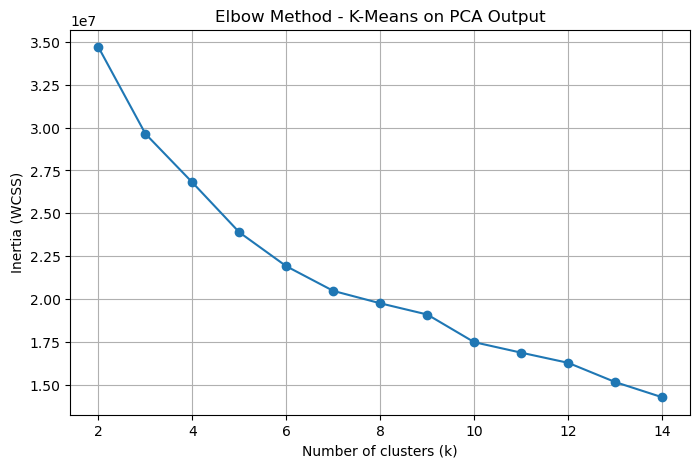

Elbow plot saved to kmeans_elbow_curve.png


In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertia_values = []
k_values = range(2, 30)  

print("Running K-Means for Elbow Method...")
for k in k_values:
    kmeans_test = KMeans(n_clusters=k, random_state=42, n_init="auto")
    kmeans_test.fit(X_pca)  # Using PCA-transformed data
    inertia_values.append(kmeans_test.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8,5))
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method - K-Means on PCA Output")
plt.grid(True)
plt.savefig("kmeans_elbow_curve.png", dpi=200)
plt.show()

print("Elbow plot saved to kmeans_elbow_curve.png")
